# XGBOOST: Predicción de Readmisión Temprana (<30 días)
- Trabajaremos con el dataset diabetic_data.csv.

- Nuevo Objetivo: Predecir específicamente si un paciente será readmitido en menos de 30 días (clase 1).

- Los pacientes que no son readmitidos o que lo son después de 30 días se considerarán clase 0.

- Esto nos ayuda a identificar los casos más urgentes.

In [2]:
# Importo librerias que se utilizaran
import pandas as pd
import seaborn as sns

# Configuración de estilo de seaborn
sns.set_style("whitegrid")

# Carga de datos
data = pd.read_csv('../data/raw/diabetic_data.csv')

data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Primero eliminaré las filas identificatorias, en este caso son las siguientes: encounter_id, patient_nbr, payer code
import numpy as np
data.drop(['payer_code', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,6,25,1,1,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),?,1,1,7,3,?,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),?,1,1,7,2,?,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),?,1,1,7,1,?,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Ahora detecto que el data set tiene nulos en forma de ' ? ', creare un arreglo para eliminarlos, ya que son nulos
data.isnull().sum()

race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

In [5]:
import numpy as np

data.replace('?', np.nan, inplace=True)
print("Total de valores nulos: ")
data.isnull().sum()

Total de valores nulos: 


race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

Antes de eliminar los valores nulos, primero analizare su importancia para valorar su respectivo manejo.
Primero analizaré las columnas con más nulos:
- **weight (Peso) :** Contiene 98569 esto es mas del 90% de sus valores totales, es decir el total de filas (pacientes) es de 101,7666, por lo que procedere a eliminar la columna directamente, ya que un porcentaje tan alto no es posible rellenar valores, esto nos daria mas ruido.
- **payer_code (Codigo de pagador):** Contiene 40256 valores nulos, debido a la naturaleza de la variable el codigo de pagador no es relevante para predecir la readmisión, aparte considerando sus valores nulos no nos servira para entrenar el modelo, procedere a elimianarla.


In [6]:
# Elimino las columnas que poseen la mayor cantidad de nulos, en este caso weight ya que payer code lo eliminamos anteriormente
data.drop(['weight'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   medical_specialty         51817 non-null   object
 8   num_lab_procedures        101766 non-null  int64 
 9   num_procedures            101766 non-null  int64 
 10  num_medications           101766 non-null  int64 
 11  number_outpatient         101766 non-null  int64 
 12  number_emergency          101766 non-null  int64 
 13  number_inpatient          101766 non-null  int64 
 14  diag

- Pasamos de 101,766 filas a 99,139 filas. Perdimos 2,627 filas, lo cual es solo el 2.6% del total. al ser un porcentaje tan pequeño, no es tan relevante.
- Pasamos de 50 a 43 columnas.

- Ahora muestra 99,139 "Non-Null Count" para todas las columnas, y el chequeo final confirma 0 nulos.

In [7]:
data.duplicated().sum()

np.int64(0)

In [8]:
def segmentar_alta(discharge_id):
    """
    Transforma el ID numérico de alta en dos categorías:
    - 'Discharged to home' si el ID es 1.
    - 'Otherwise' para cualquier otro ID.
    """
    # El ID 1 corresponde a "Discharged to home" en el mapeo estándar de este dataset
    if discharge_id == 1:
        return 'Discharged to home'
    else:
        return 'Otherwise'

# Aplicar la transformación
# Suponiendo que tu columna se llama 'discharge_disposition_id'
# (Uso 'apply' para iterar sobre la columna y generar la nueva categoría)

# Si tienes el dataframe cargado, descomenta la siguiente línea:
data['discharge_segment'] = data['discharge_disposition_id'].apply(segmentar_alta)
data['discharge_segment'].value_counts()

discharge_segment
Discharged to home    60234
Otherwise             41532
Name: count, dtype: int64

In [9]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,No,No,No,No,No,No,No,No,NO,Otherwise
1,Caucasian,Female,[10-20),1,1,7,3,NaN,59,0,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home
2,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,11,5,...,No,No,No,No,No,No,No,Yes,NO,Discharged to home
3,Caucasian,Male,[30-40),1,1,7,2,NaN,44,1,...,Up,No,No,No,No,No,Ch,Yes,NO,Discharged to home
4,Caucasian,Male,[40-50),1,1,7,1,NaN,51,0,...,Steady,No,No,No,No,No,Ch,Yes,NO,Discharged to home


In [10]:
# Elimino la columna discharge_disposition_id para reemplazarla por discharge_segment
data.drop(columns=['discharge_disposition_id'], inplace=True)
data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment
0,Caucasian,Female,[0-10),6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,No,NO,Otherwise
1,Caucasian,Female,[10-20),1,7,3,NaN,59,0,18,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home
2,AfricanAmerican,Female,[20-30),1,7,2,NaN,11,5,13,...,No,No,No,No,No,No,No,Yes,NO,Discharged to home
3,Caucasian,Male,[30-40),1,7,2,NaN,44,1,16,...,Up,No,No,No,No,No,Ch,Yes,NO,Discharged to home
4,Caucasian,Male,[40-50),1,7,1,NaN,51,0,8,...,Steady,No,No,No,No,No,Ch,Yes,NO,Discharged to home


El data set no contiene valores duplicados.

### Analisis de variable objetivo
- El objetivo es entender la distrbución de la variable objetivo readdmited

In [11]:
data['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

C:\Users\asjer\AppData\Local\Temp\ipykernel_23508\2607853986.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['readmitted'], color='blue', palette='viridis')


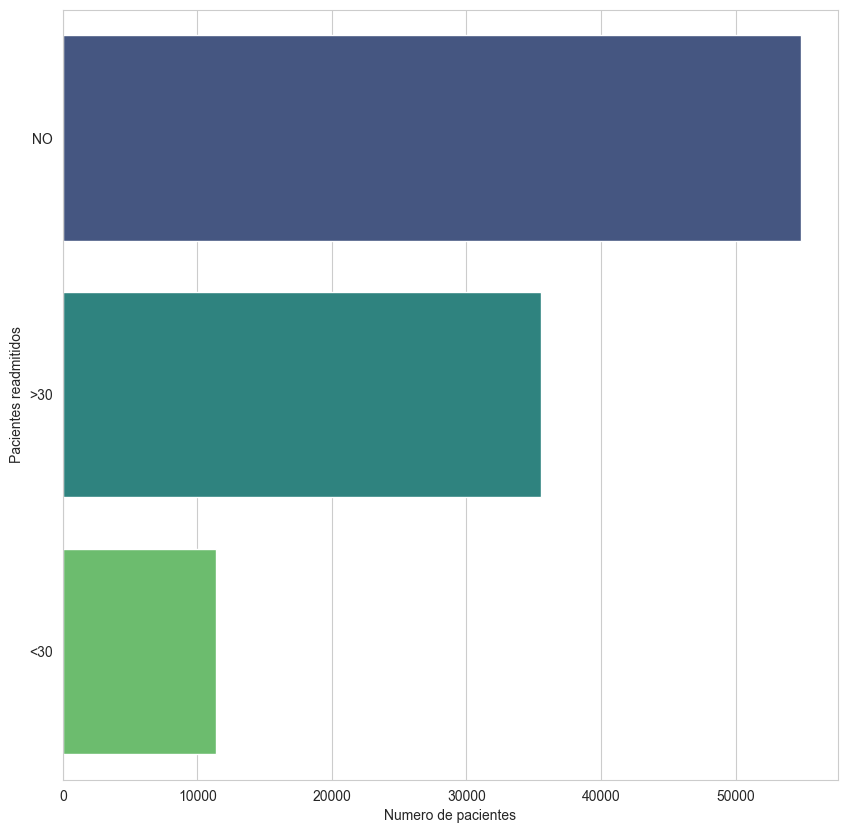

Porcentajes de cada variable: readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


In [12]:
# Graficaré para tener una representación visual de la distribución.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid") # Tema para todos los graficos.
plt.figure(figsize=(10,10))
sns.countplot(data['readmitted'], color='blue', palette='viridis')
plt.xlabel('Numero de pacientes')
plt.ylabel('Pacientes readmitidos')
plt.show()

readmitted_norm = data['readmitted'].value_counts(normalize=True)
print(f"Porcentajes de cada variable: {readmitted_norm*100}")

Se puede observar una distribución desbalanceada, con un sesgo hacia los pacientes que no fueron readmitidos.
- mayor 30:  esta variable la manejaremos como pacientes que no fueron readmitidos y representa el 35.3%.
- NO: Pacientes que no fueron readmitidos y representa el 53.3%.
- Menor a 30: Aquellos que fueron readmitidos y representa el 11.2%.

- Para este analisis voy a optar por una clasificacion binaria, simplificando las variables mayor a 30 y NO como pacientes que no fueron readmitido, de esta manera la clase minoritaria es los pacientes que fueron readmitdos.
- De este modo creare una nueva columna llamada target que sera la variable objetivo y la dividire en dos grupos:
- 1: Aquellos que fueron readmitidos (<30 )
- 0: Aquellos que no fueron readmitidos (>30) Dias y (NO)

In [13]:
data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment
0,Caucasian,Female,[0-10),6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,No,NO,Otherwise
1,Caucasian,Female,[10-20),1,7,3,NaN,59,0,18,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home
2,AfricanAmerican,Female,[20-30),1,7,2,NaN,11,5,13,...,No,No,No,No,No,No,No,Yes,NO,Discharged to home
3,Caucasian,Male,[30-40),1,7,2,NaN,44,1,16,...,Up,No,No,No,No,No,Ch,Yes,NO,Discharged to home
4,Caucasian,Male,[40-50),1,7,1,NaN,51,0,8,...,Steady,No,No,No,No,No,Ch,Yes,NO,Discharged to home


In [14]:
mapping = {'<30': 1, '>30': 0, 'NO': 0}
data['target'] = data['readmitted'].map(mapping)

data['target'].value_counts()

target
0    90409
1    11357
Name: count, dtype: int64

- Pasaré las edades a numeros enteros ya que estan como rangos de edad, es decir 0-10, 10-20, etc.
- En este script voy a organizar las edades segun la media del rango de edad, de esta manera el modelo puede trabajar con enteros.


In [15]:
# Convertimos '[0-10)' en 5, '[10-20)' en 15, etc.
data['age'] = data['age'].str.strip()
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, 
    '[80-90)': 85, '[90-100)': 95
}
data['age'] = data['age'].map(age_mapping)

data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment,target
0,Caucasian,Female,5,6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,NO,Otherwise,0
1,Caucasian,Female,15,1,7,3,NaN,59,0,18,...,No,No,No,No,No,Ch,Yes,>30,Discharged to home,0
2,AfricanAmerican,Female,25,1,7,2,NaN,11,5,13,...,No,No,No,No,No,No,Yes,NO,Discharged to home,0
3,Caucasian,Male,35,1,7,2,NaN,44,1,16,...,No,No,No,No,No,Ch,Yes,NO,Discharged to home,0
4,Caucasian,Male,45,1,7,1,NaN,51,0,8,...,No,No,No,No,No,Ch,Yes,NO,Discharged to home,0


Estas dos columnas son características de resumen o agregadas. 
En lugar de describir el estado de un medicamento, describen el estado del tratamiento completo del paciente desde dos perspectivas diferentes.

In [16]:
# Defino los medicamentos que se obtuvieron desde la informacion del data set, en total 24 medicamentos
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'sitagliptin', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

# Corroboración: Verificamos que todas las columnas de la lista existan en el DataFrame.
existing_med_cols = [col for col in med_cols if col in data.columns]
missing_cols = [col for col in med_cols if col not in data.columns]

if missing_cols:
    print(f"Las siguientes columnas no se encontraron y serán ignoradas: {missing_cols}\n")

print(f"Se encontraron {len(existing_med_cols)} columnas de medicamentos.\n")






Las siguientes columnas no se encontraron y serán ignoradas: ['sitagliptin']

Se encontraron 22 columnas de medicamentos.



Genero caracteristicas para determinar si un paciente tuvo cambio en sus medicamentos respetando la siguiente jerarquia:
1. No
2. Steady
3. Cambio

In [17]:
# CREAR CARACTERÍSTICAS DE RESUMEN 

# Característica 1: Número de cambios en la dosis ('Up' o 'Down')
change_values = ['Up', 'Down']
data['numchange'] = data[existing_med_cols].isin(change_values).sum(axis=1)

# Característica 2: Número total de medicamentos que toma el paciente (cualquier estado que no sea 'No')
taking_med_values = ['Steady', 'Up', 'Down']
data['nummeds'] = data[existing_med_cols].isin(taking_med_values).sum(axis=1)

print(" DataFrame con Características de Resumen ('numchange' y 'nummeds')")
print(data[['numchange', 'nummeds']].head(15))
print("\n")
print(f" Valores unicos por columna \n{data[['numchange', 'nummeds']].nunique()}")


 DataFrame con Características de Resumen ('numchange' y 'nummeds')
    numchange  nummeds
0           0        0
1           1        1
2           0        1
3           1        1
4           0        2
5           0        1
6           0        3
7           0        1
8           0        2
9           0        2
10          0        1
11          1        2
12          2        3
13          0        1
14          0        1


 Valores unicos por columna 
numchange    5
nummeds      7
dtype: int64


- **numchange: La Intensidad del Ajuste del Tratamiento**
- ¿Qué Mide?: El número de medicamentos cuya dosis fue cambiada (subida o bajada) durante la visita.
- Cálculo: Es la suma de cuántas veces aparece 'Up' o 'Down' en las columnas de medicamentos para un paciente.
- Jerarquía y Significado: La jerarquía aquí es real y muy significativa. Representa el nivel de intervención médica.
- numchange = 0: Paciente Estable. No se le ajustó la dosis de ningún medicamento. Es el estado de menor intervención.
- numchange = 1: Ajuste Menor. Se le ajustó la dosis de un solo medicamento.
- numchange = 2: Ajuste Moderado. Se le ajustaron dos medicamentos.
- numchange = 3: Ajuste Significativo.
- numchange = 4 o más: Ajuste Agresivo. El equipo médico está haciendo cambios importantes en el tratamiento.
- Jerarquía de numchange: 4 > 3 > 2 > 1 > 0 Un valor más alto indica una intervención médica más intensa. Para un modelo que intenta predecir, por ejemplo, una readmisión hospitalaria, un numchange alto podría ser una señal de alerta muy potente de que el paciente está en una condición inestable.


- nummeds: La Complejidad del Tratamiento
- ¿Qué Mide?: El número total de medicamentos diferentes que un paciente está tomando (sin importar si la dosis es estable o se está ajustando).
- Cálculo: Es la suma de cuántas veces aparece 'Steady', 'Up' o 'Down' (es decir, cualquier cosa que no sea 'No').
- Jerarquía y Significado: La jerarquía aquí también es real y útil. Representa la complejidad o "carga" del régimen de medicación del paciente.
- nummeds = 0: Sin Medicación. El paciente no toma ninguno de los medicamentos de la lista.
- nummeds = 1: Manejo Simple. El paciente está en monoterapia (un solo medicamento).
- nummeds = 2: Terapia Dual.
- nummeds = 3 o más: Polifarmacia. El paciente está tomando múltiples medicamentos, lo que puede indicar una condición más difícil de manejar o comorbilidades.
- Jerarquía de nummeds: 4 > 3 > 2 > 1 > 0 Un valor más alto indica que el paciente tiene un esquema de medicación más complejo. Esto puede correlacionarse con la gravedad de la enfermedad o la duración de la misma.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  int64 
 3   admission_type_id         101766 non-null  int64 
 4   admission_source_id       101766 non-null  int64 
 5   time_in_hospital          101766 non-null  int64 
 6   medical_specialty         51817 non-null   object
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101745 non-null  object
 14  diag

- Ahora agrupare los diagnosticos en 9 categorias segun su codificacion icd9, al hacer este cambio el modelo no tratará de predecir cada diagnsotico segun su etiqueta icd9 que pueden ser miles y al hacer one hot codificación se crearán miles de variables.
- En su defecto las agrupare en 9 categorias:
    - 0: Diabetes Mellitus
    - 1: Hipertension
    - 2: Obesidad
    - 3: Cardiopatia
    - 4: Neumonía
    - 5: Infeccion
    - 6: Enfermedad renal
    - 7: Enfermedad gastrointestinal
    - 8: Enfermedad respiratoria
De esta manera el modelo no solo podrá predecir si el paciente tiene alguna de estas enfermedades si no que tambien cual es mas relevante para su reingreso.

In [19]:
import pandas as pd
import numpy as np

def map_icd9_to_category(code):
    """
    Transforma códigos ICD-9 a categorías generales.
    Maneja códigos numéricos, alfanuméricos (V, E) y valores nulos (?).
    """
    if code == '?' or pd.isna(code):
        return 'Other'
    
    try:
        # Si empieza con V o E, usualmente son factores suplementarios o externos
        if str(code).startswith('V') or str(code).startswith('E'):
            return 'Other'
        
        # Convertimos a float para manejar decimales
        code_num = float(code)
        
        # Rangos estándar de agrupación ICD-9
        if 390 <= code_num <= 459 or code_num == 785:
            return 'Circulatory'
        elif 460 <= code_num <= 519 or code_num == 786:
            return 'Respiratory'
        elif 520 <= code_num <= 579 or code_num == 787:
            return 'Digestive'
        elif 250 <= code_num < 251:
            return 'Diabetes'
        elif 800 <= code_num <= 999:
            return 'Injury'
        elif 710 <= code_num <= 739:
            return 'Musculoskeletal'
        elif 580 <= code_num <= 629 or code_num == 788:
            return 'Genitourinary'
        elif 140 <= code_num <= 239:
            return 'Neoplasms'
        else:
            return 'Other' # Incluye infecciosas, mentales, etc.
            
    except ValueError:
        return 'Other'

# Aplicamos la función a las 3 columnas de diagnóstico
diag_cols = ['diag_1', 'diag_2', 'diag_3']
for col in diag_cols:
    data[f'{col}_group'] = data[col].apply(map_icd9_to_category)

# Verificamos el resultado
print(data[['diag_1', 'diag_1_group']].head(15))

    diag_1 diag_1_group
0   250.83     Diabetes
1      276        Other
2      648        Other
3        8        Other
4      197    Neoplasms
5      414  Circulatory
6      414  Circulatory
7      428  Circulatory
8      398  Circulatory
9      434  Circulatory
10   250.7     Diabetes
11     157    Neoplasms
12     428  Circulatory
13     428  Circulatory
14     518  Respiratory


Nuevas columnas creadas para identificar los diagnosticos
- El cambio es pasar de una codificacion idc9 a una mas entendible con el nombre del diagnostico con respecto a la version de icd9 que se esta usando.
- De esta manera el modelo puede entender mejor los datos.

In [20]:
data.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)
print('Columnas eliminadas.')

Columnas eliminadas.


In [21]:
data.drop(columns=['readmitted'], inplace=True)
data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,metformin-pioglitazone,change,diabetesMed,discharge_segment,target,numchange,nummeds,diag_1_group,diag_2_group,diag_3_group
0,Caucasian,Female,5,6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,Otherwise,0,0,0,Diabetes,Other,Other
1,Caucasian,Female,15,1,7,3,NaN,59,0,18,...,No,Ch,Yes,Discharged to home,0,1,1,Other,Diabetes,Other
2,AfricanAmerican,Female,25,1,7,2,NaN,11,5,13,...,No,No,Yes,Discharged to home,0,0,1,Other,Diabetes,Other
3,Caucasian,Male,35,1,7,2,NaN,44,1,16,...,No,Ch,Yes,Discharged to home,0,1,1,Other,Diabetes,Circulatory
4,Caucasian,Male,45,1,7,1,NaN,51,0,8,...,No,Ch,Yes,Discharged to home,0,0,2,Neoplasms,Neoplasms,Diabetes


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

X = data.drop('target', axis=1)
y = data['target']

# Agregar logica 
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Crear el transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
)



In [23]:
import pickle
model_columns = list(X.columns)
pickle.dump(model_columns, open("../models/model_columns.pkl", "wb"))

Creo un flujo Pipeline para XGBoost para evitar fuga de datos y que aplique standarscaler a variables numericas y OneHotEncoder a variables categoricas.


In [59]:
# Encadenamos el preprocesador y el modelo en un solo objeto.
# El pipeline se encargará de aplicar cada paso en orden.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Entrenamos el pipeline
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:,1]





### Evaluar rendimiento del modelo utilizando metricas


Accuracy: 0.8874

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27123
           1       0.41      0.02      0.04      3407

    accuracy                           0.89     30530
   macro avg       0.65      0.51      0.49     30530
weighted avg       0.84      0.89      0.84     30530


AUC: 0.5086

Confusion Matrix:
[[27022   101]
 [ 3336    71]]


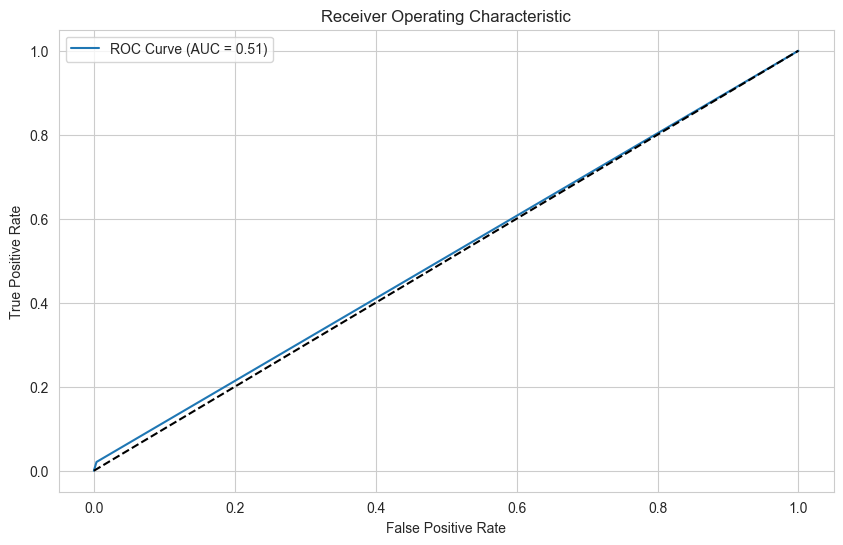

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_pred)
print(f"\nAUC: {auc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f' Curva ROC(AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC (xgboost base)')
plt.legend()
plt.show()


In [61]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.5085578356632762


In [62]:
# Pasos del Pipeline
print("\nPasos del Pipeline:")
model_pipeline.steps


Pasos del Pipeline:


[('preprocessor',
  ColumnTransformer(transformers=[('num', StandardScaler(),
                                   Index(['age', 'admission_type_id', 'admission_source_id', 'time_in_hospital',
         'num_lab_procedures', 'num_procedures', 'num_medications',
         'number_outpatient', 'number_emergency', 'number_inpatient',
         'number_diagnoses', 'numchange', 'nummeds'],
        dtype='object')),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'),
                                   I...
         'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
         'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
         'tolazamide', 'examide', 'citoglipton', 'insulin',
         'glyburide-metformin', 'glipizide-metformin',
         'glimepiride-pioglitazone', 'metformin-rosiglitazone',
         'metformin-pioglitazone', 'change', 'diabetesMed', 'discharge_segment',
         'diag_1_group', 'diag_2_group', 'dia


Accuracy: 0.8874

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27123
           1       0.41      0.02      0.04      3407

    accuracy                           0.89     30530
   macro avg       0.65      0.51      0.49     30530
weighted avg       0.84      0.89      0.84     30530


AUC: 0.6429

Confusion Matrix:
[[27022   101]
 [ 3336    71]]


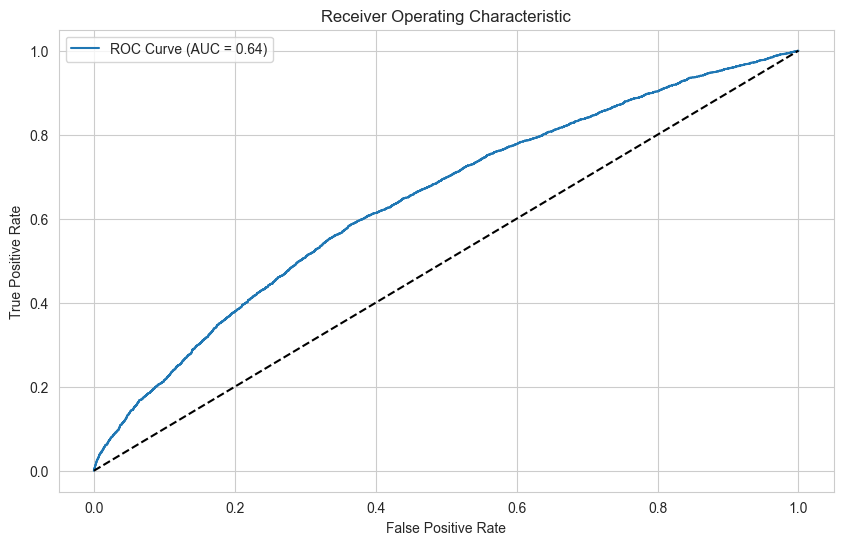

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC: {auc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC (XGBoost Optimizada)')
plt.legend()
plt.show()

In [64]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    """
    Función objetivo para optimizar los hiperparámetros de XGBoost dentro de un Pipeline.
    """
    
    # Definir el espacio de búsqueda de hiperparámetros
    # Usamos el prefijo 'classifier__' porque el modelo está dentro de un Pipeline llamado 'classifier'
    param_grid = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'classifier__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'classifier__max_depth': trial.suggest_int('max_depth', 3, 10),
        'classifier__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'classifier__gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'classifier__subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'classifier__reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'classifier__reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        # Importante para data desbalanceada (scale_pos_weight)
        # Se suele calcular como: (total_negativos / total_positivos)
        # 'classifier__scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0) 
    }

    # Actualizar los parámetros del Pipeline existente
    model_pipeline.set_params(**param_grid)

    # Evaluación con Validación Cruzada (Cross-Validation)
    # cv=5 lo cambie a 5 para probar mejor robustez
    cv_scores = cross_val_score(
        model_pipeline, 
        X_train, 
        y_train, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )

    # Retornar el promedio de los scores (Optuna intentará maximizar esto)
    return cv_scores.mean()

In [65]:
# Crear el estudio
study = optuna.create_study(direction='maximize', study_name='xgboost_optimization')

# Iniciar la optimización (esto puede tardar unos minutos dependiendo de tu hardware)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("-" * 50)
print("¡Optimización terminada!")
print(f"Mejor AUC ROC obtenido: {study.best_value:.4f}")
print("Mejores Hiperparámetros encontrados:")
print(study.best_params)

[I 2025-11-24 16:38:14,220] A new study created in memory with name: xgboost_optimization


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-24 16:38:29,160] Trial 0 finished with value: 0.6530926945318695 and parameters: {'n_estimators': 983, 'learning_rate': 0.012897342083153103, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 3.903688558060076, 'subsample': 0.887219156126891, 'colsample_bytree': 0.8674630351539192, 'reg_alpha': 0.134491245426866, 'reg_lambda': 0.001545992386223816}. Best is trial 0 with value: 0.6530926945318695.
[I 2025-11-24 16:38:38,726] Trial 1 finished with value: 0.6527178601974722 and parameters: {'n_estimators': 581, 'learning_rate': 0.03880312579670996, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 2.5758211490284184, 'subsample': 0.8965482070743787, 'colsample_bytree': 0.8582807179644509, 'reg_alpha': 0.5898964809616793, 'reg_lambda': 0.398932201314862}. Best is trial 0 with value: 0.6530926945318695.
[I 2025-11-24 16:38:51,972] Trial 2 finished with value: 0.6543542665181495 and parameters: {'n_estimators': 607, 'learning_rate': 0.013971592777336178, 'max_depth': 8, 'min_child_we

In [66]:
# 1. Obtener los mejores parámetros del estudio
best_params = study.best_params

# 2. Ajustar las claves del diccionario para que coincidan con el Pipeline
# (Añadimos el prefijo 'classifier__' a cada clave que nos dio Optuna)
pipeline_params = {f'classifier__{k}': v for k, v in best_params.items()}

# 3. Configurar el pipeline con los ganadores
model_pipeline.set_params(**pipeline_params)

# 4. Entrenar modelo definitivo
model_pipeline.fit(X_train, y_train)

# 5. Generar predicciones
# predict() nos da clases (0 o 1)
y_pred = model_pipeline.predict(X_test)
# predict_proba() nos da la probabilidad (0.0 a 1.0), necesaria para el AUC y la curva ROC
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("Modelo entrenado y predicciones generadas.")

Modelo entrenado y predicciones generadas.


### Evaluar el modelo final xgboost con optimización de hiperparámetros usando optuna

In [67]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Métricas Numéricas
auc_final = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC ROC Final (Test Set): {auc_final:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

AUC ROC Final (Test Set): 0.6588
Accuracy: 0.8889

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27123
           1       0.64      0.01      0.02      3407

    accuracy                           0.89     30530
   macro avg       0.77      0.50      0.48     30530
weighted avg       0.86      0.89      0.84     30530



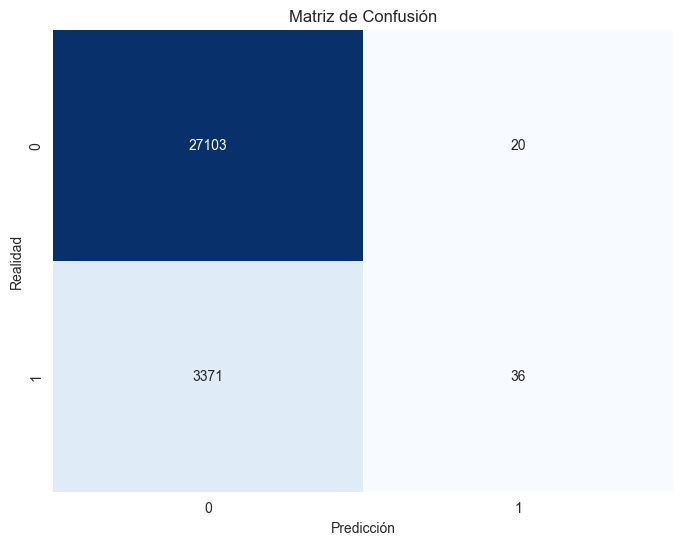

In [70]:
# Visualización: Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.savefig('../reports/figures/matriz_confusion.png')
plt.show()


In [71]:
# --- Visualización: Importancia de los Hiperparámetros (Optuna) ---
print("¿Qué hiperparámetros importaron más?")
optuna.visualization.plot_param_importances(study)
plt.show()

¿Qué hiperparámetros importaron más?


CURVA ROC

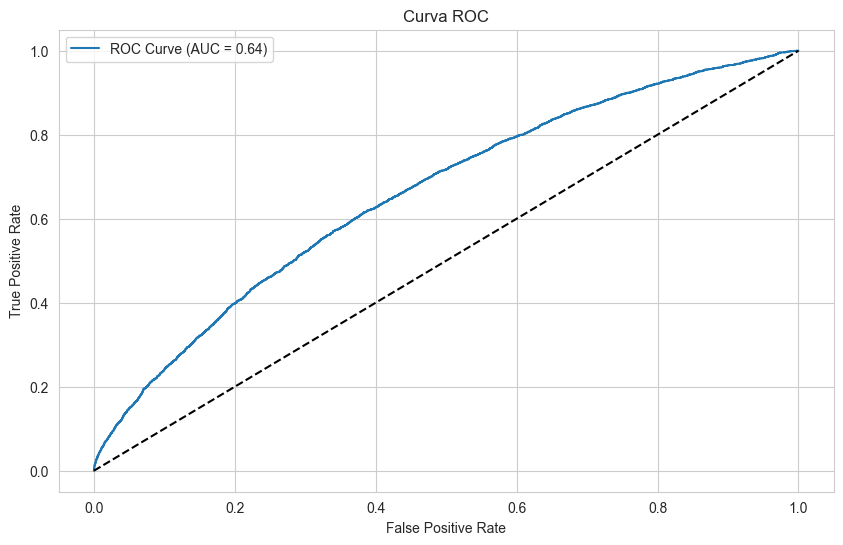

In [72]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.savefig('../reports/figures/roc_curve.png')
plt.show()

Características más Importantes (por Ganancia/Gain
                                  feature  importance
9                        number_inpatient    0.053910
173  discharge_segment_Discharged to home    0.029905
174           discharge_segment_Otherwise    0.028272
8                        number_emergency    0.014790
190                diag_2_group_Neoplasms    0.013126
171                        diabetesMed_No    0.010222
153                          insulin_Down    0.010004
175              diag_1_group_Circulatory    0.009889
183              diag_1_group_Respiratory    0.009864
10                       number_diagnoses    0.009621


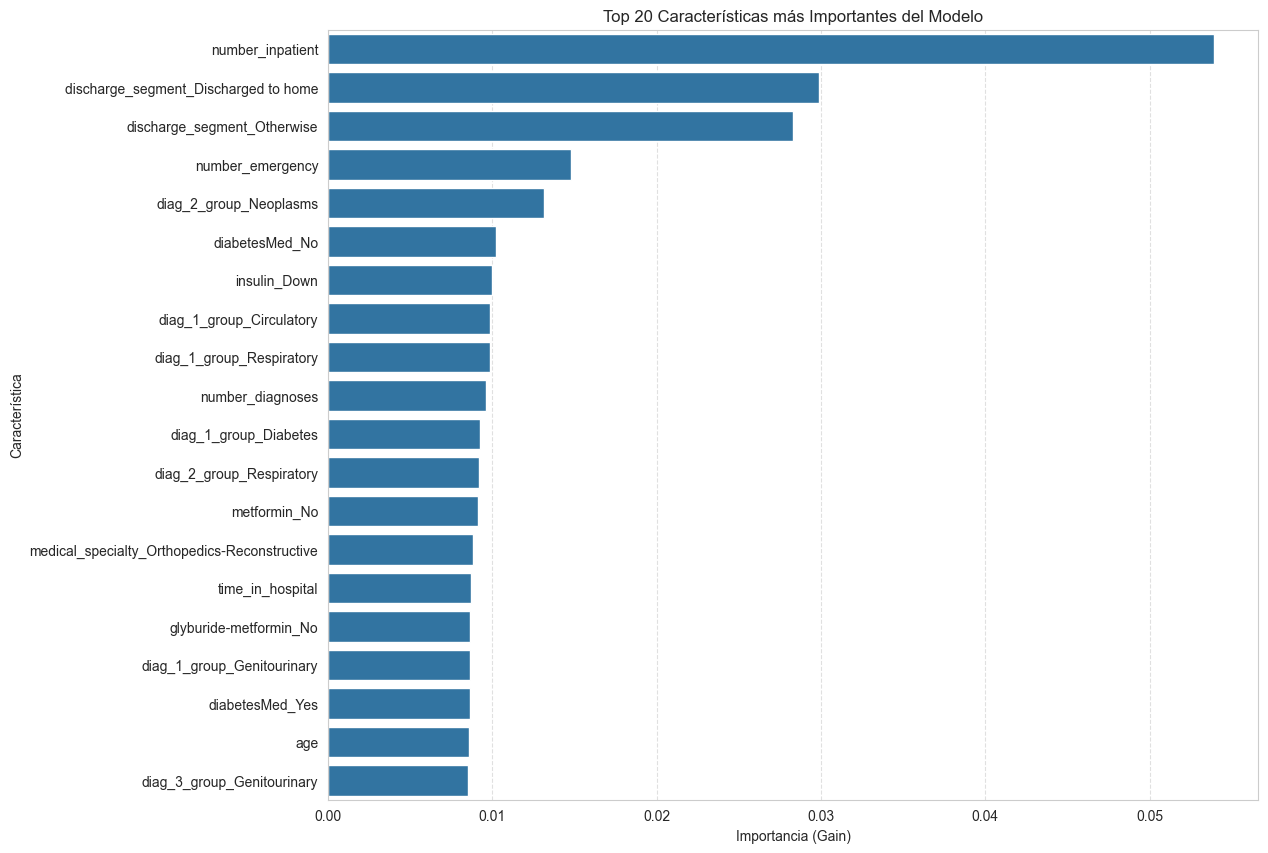

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Acceder al modelo entrenado DENTRO del pipeline
# Usamos .named_steps para obtener el paso 'classifier' por su nombre.
trained_model = model_pipeline.named_steps['classifier']
importances = trained_model.feature_importances_

#  Obtener los nombres de las características finales
# Accedemos al preprocesador para que nos dé los nombres de las columnas que generó.
preprocessor = model_pipeline.named_steps['preprocessor']

# Nombres de las columnas numéricas (no cambian)
num_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out()

# Nombres de las columnas categóricas (generadas por OneHotEncoder)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Combinamos los nombres en el orden correcto
final_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Se crea data frame que contiene las variables y sus importancias
df_imp = pd.DataFrame({
    "feature": final_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Visualizar los resultados
print("Características más Importantes (por Ganancia/Gain")
print(df_imp.head(10))

# Graficar para una mejor interpretación
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=df_imp.head(20))
plt.title('Top 20 Características más Importantes del Modelo')
plt.xlabel('Importancia (Gain)')
plt.ylabel('Característica')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [79]:
import plotly.express as px
import numpy as np

# Asumiendo que df_imp es tu DataFrame con las columnas 'feature' e 'importance'

# Importancia de las características
fig_imp = px.bar(df_imp.head(20), 
                 x='importance', 
                 y='feature', 
                 orientation='h',
                 title='<b>Top 20 Variables más Influyentes (XGBoost)</b>',
                 color='importance',
                 color_continuous_scale='Viridis',
                 text_auto='.4f',
                 labels={'importance': 'Importancia', 'feature': 'Característica'}) # Usamos labels para las etiquetas del gráfico
fig_imp.write_image("../reports/figures/feature_importance_xgboost.png")

fig_imp.update_layout(yaxis={'categoryorder': 'total ascending'}, height=800)


fig_imp.show()



In [80]:
# MATRIZ DE CONFUSIÓN
cm = confusion_matrix(y_test, y_pred)
# Convertimos a texto para mostrar en el heatmap
z_text = [[str(y) for y in x] for x in cm]

fig_cm = px.imshow(cm, 
                   text_auto=True,
                   aspect="auto",
                   labels=dict(x="Predicción", y="Realidad", color="Cantidad"),
                   x=['No Readmitido (0)', 'Readmitido (1)'],
                   y=['No Readmitido (0)', 'Readmitido (1)'],
                   color_continuous_scale='Blues',
                   title="<b>Matriz de Confusión Interactiva</b>")
fig_imp.write_image("../reports/figures/confusion_matrix_xgboost.png")
fig_cm.show()





In [81]:
# CURVA ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

fig_roc = px.area(
    x=fpr, y=tpr,
    title=f'<b>Curva ROC (AUC = {auc_score:.4f})</b>',
    labels=dict(x='Tasa de Falsos Positivos (FPR)', y='Tasa de Verdaderos Positivos (TPR)'),
    width=700, height=600
)
fig_roc.add_shape(
    type='line', line=dict(dash='dash', color='grey'),
    x0=0, x1=1, y0=0, y1=1
)
fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
fig_roc.write_image("../reports/figures/roc_curve_xgboost.png")
fig_roc.show()

In [82]:
# distribución de las probabilidades (Separación de Clases)
# Creamos un DF temporal para graficar
df_prob = pd.DataFrame({'Probabilidad': y_pred_proba, 'Clase Real': y_test})
df_prob['Clase Real'] = df_prob['Clase Real'].map({0: '0 - No Readmitido', 1: '1 - Readmitido'})

fig_hist = px.histogram(df_prob, 
                        x="Probabilidad", 
                        color="Clase Real", 
                        nbins=50,
                        title="<b>Distribución de Probabilidades Predichas por Clase Real</b>",
                        marginal="box", # Muestra boxplots arriba para ver outliers
                        opacity=0.6,
                        barmode='overlay', # Superponer para comparar
                        color_discrete_map={'0 - No Readmitido': '#636EFA', '1 - Readmitido': '#EF553B'})
fig_hist.write_image("../reports/figures/distribucion_probabilidades.png")
fig_hist.update_layout(xaxis_title="Probabilidad asignada por el modelo (de ser Clase 1)")
fig_hist.show()

### Guardado de modelo
- Para produccir guardare el modelo por columnas y el modelo total.


In [84]:
import pickle
pickle.dump(model_pipeline, open("../models/modelo_optuna.pkl", "wb"))

Entrenando modelo con las 10 características más importantes según el modelo XGBoost.

Estas características son basadas en los datos en crudo, al generar el one hot encoding se generan las que el modelo toma de importancia.

In [28]:
data.head()
data.to_csv("../data/processed/data.csv", index=False)

In [ ]:
TOP_10_FEATURES = [
    'number_inpatient',      # Most important
    'discharge_segment',     # Generó las vars 2 y 3 más importantes
    'number_emergency',      # Visitas de emergencia
    'diag_1_group',          # Diagnóstico primario (Circulatory/Resp/Diabetes)
    'diag_2_group',          # Diagnóstico secundario
    'diabetesMed',           # Indicador general de medicación
    'insulin',               # Insulina (Se redujo la dosis de insulina)
    'number_diagnoses',      # Cantidad de diagnósticos
    'age',                   # Edad 
    'time_in_hospital'       # Tiempo en hospital
]
data_top_10 = data[TOP_10_FEATURES + ['target']]
data_top_10.head()

,number_inpatient,discharge_segment,number_emergency,diag_1_group,diag_2_group,diabetesMed,insulin,number_diagnoses,age,time_in_hospital,target
0,0,Otherwise,0,Diabetes,Other,No,No,1,5,1,0
1,0,Discharged to home,0,Other,Diabetes,Yes,Up,9,15,3,0
2,1,Discharged to home,0,Other,Diabetes,Yes,No,6,25,2,0
3,0,Discharged to home,0,Other,Diabetes,Yes,Up,7,35,2,0
4,0,Discharged to home,0,Neoplasms,Neoplasms,Yes,Steady,5,45,1,0


In [120]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np

X = data_top_10.drop(columns=['target'])
y = data_top_10['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline_10 = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

pipeline_10.fit(X_train, y_train)

y_pred = pipeline_10.predict(X_test)
y_pred_proba = pipeline_10.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))



c:\Users\asjer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[17:29:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.41      0.02      0.03      2285

    accuracy                           0.89     20354
   macro avg       0.65      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354

ROC AUC Score: 0.6440779467669097


Optimización de hiperparámetros con Optuna 

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    """
    Función objetivo para optimizar los hiperparámetros de XGBoost dentro de un Pipeline.
    """
    
    # Definir el espacio de búsqueda de hiperparámetros
    # Usamos el prefijo 'xgb__' porque el modelo está dentro de un Pipeline llamado 'xgb'
    param_grid = {
    'xgb__n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'xgb__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    'xgb__max_depth': trial.suggest_int('max_depth', 3, 10),
    'xgb__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'xgb__gamma': trial.suggest_float('gamma', 0, 5),
    'xgb__subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'xgb__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'xgb__reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1.0),
    'xgb__reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0)
}

        # Importante para data desbalanceada (scale_pos_weight)
        # Se suele calcular como: (total_negativos / total_positivos)
        # 'classifier__scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0) 
    

    # Actualizar los parámetros del Pipeline existente
    pipeline_10.set_params(**param_grid)

    # Evaluación con Validación Cruzada (Cross-Validation)
    # cv=5 lo cambie a 5 para probar mejor robustez
    cv_scores = cross_val_score(
        pipeline_10, 
        X_train, 
        y_train, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )

    # Retornar el promedio de los scores (Optuna intentará maximizar esto)
    return cv_scores.mean()

In [127]:
# Crear el estudio
study = optuna.create_study(direction='maximize', study_name='xgboost_optimization_10')

# Iniciar la optimización (esto puede tardar unos minutos dependiendo de tu hardware)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("-" * 50)
print("¡Optimización terminada!")
print(f"Mejor AUC ROC obtenido: {study.best_value:.4f}")
print("Mejores Hiperparámetros encontrados:")
print(study.best_params)

[I 2025-11-24 17:36:48,522] A new study created in memory with name: xgboost_optimization_10


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:36:56,219] Trial 0 finished with value: 0.6518665582732444 and parameters: {'n_estimators': 599, 'learning_rate': 0.024002121984417115, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 4.626229944402703, 'subsample': 0.5464016321075651, 'colsample_bytree': 0.7034752184082982, 'reg_alpha': 0.0013526623707008306, 'reg_lambda': 0.025547488710084495}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:01,595] Trial 1 finished with value: 0.6514343411907356 and parameters: {'n_estimators': 477, 'learning_rate': 0.17297687761531738, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 2.540031201303483, 'subsample': 0.873987682540706, 'colsample_bytree': 0.5083842694557721, 'reg_alpha': 0.6085154120396689, 'reg_lambda': 0.5169563091556939}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:06,575] Trial 2 finished with value: 0.6443891741422577 and parameters: {'n_estimators': 423, 'learning_rate': 0.09725293369191795, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 0.9232802481760016, 'subsample': 0.896687024806273, 'colsample_bytree': 0.7245112296831049, 'reg_alpha': 0.014652360034222808, 'reg_lambda': 0.630348213602782}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:10,146] Trial 3 finished with value: 0.646148449346047 and parameters: {'n_estimators': 481, 'learning_rate': 0.15013445361231714, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.9526869564254775, 'subsample': 0.9498963542968634, 'colsample_bytree': 0.5478431265269434, 'reg_alpha': 0.08174816213216458, 'reg_lambda': 0.0006741310376596428}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:21,595] Trial 4 finished with value: 0.5636397881983732 and parameters: {'n_estimators': 919, 'learning_rate': 0.2789597714318846, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.013639691772038831, 'subsample': 0.5530300376729483, 'colsample_bytree': 0.6527395311719735, 'reg_alpha': 0.20010302707538552, 'reg_lambda': 0.006789187896214871}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:25,147] Trial 5 finished with value: 0.6466309155501819 and parameters: {'n_estimators': 445, 'learning_rate': 0.20698225091169545, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 3.7009757981753295, 'subsample': 0.5615660473877466, 'colsample_bytree': 0.8573747544033599, 'reg_alpha': 0.0681443764705286, 'reg_lambda': 0.027449074221740342}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:29,895] Trial 6 finished with value: 0.6457773634295584 and parameters: {'n_estimators': 615, 'learning_rate': 0.0663399803728941, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.847592270956114, 'subsample': 0.9372968518254555, 'colsample_bytree': 0.8919460501073198, 'reg_alpha': 0.10732587733917824, 'reg_lambda': 0.0362727349549589}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:34,169] Trial 7 finished with value: 0.6511673209315902 and parameters: {'n_estimators': 558, 'learning_rate': 0.03670502626803419, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 4.048024787886265, 'subsample': 0.9864033187441466, 'colsample_bytree': 0.6476263600642974, 'reg_alpha': 5.6593660753480466e-05, 'reg_lambda': 0.0011841745212235952}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:38,759] Trial 8 finished with value: 0.6503012275982349 and parameters: {'n_estimators': 625, 'learning_rate': 0.1841376865420095, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 4.174419373532527, 'subsample': 0.5035606635716059, 'colsample_bytree': 0.7148467296911978, 'reg_alpha': 0.018876943141657374, 'reg_lambda': 9.222055126633454e-05}. Best is trial 0 with value: 0.6518665582732444.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:44,361] Trial 9 finished with value: 0.6519562551529731 and parameters: {'n_estimators': 825, 'learning_rate': 0.05636648514796815, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 3.791682102494234, 'subsample': 0.7549886950503444, 'colsample_bytree': 0.5932203516921418, 'reg_alpha': 0.07073170206137125, 'reg_lambda': 0.15996915652793317}. Best is trial 9 with value: 0.6519562551529731.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:45,865] Trial 10 finished with value: 0.6498196722070602 and parameters: {'n_estimators': 128, 'learning_rate': 0.11292725493445499, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.9078516838904953, 'subsample': 0.7215724967573751, 'colsample_bytree': 0.8379357951369016, 'reg_alpha': 0.0007374908118175001, 'reg_lambda': 3.433107972311506e-05}. Best is trial 9 with value: 0.6519562551529731.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:52,536] Trial 11 finished with value: 0.650599648553105 and parameters: {'n_estimators': 856, 'learning_rate': 0.012356054003605468, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.909081208381215, 'subsample': 0.7200534606504485, 'colsample_bytree': 0.9819020254940631, 'reg_alpha': 0.000533099824173733, 'reg_lambda': 0.08559906557152316}. Best is trial 9 with value: 0.6519562551529731.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:37:57,736] Trial 12 finished with value: 0.650345713674305 and parameters: {'n_estimators': 771, 'learning_rate': 0.060303556972664485, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 4.830162157736292, 'subsample': 0.7945559993300416, 'colsample_bytree': 0.6000781213709047, 'reg_alpha': 0.0036386339420120505, 'reg_lambda': 0.14979795461830064}. Best is trial 9 with value: 0.6519562551529731.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:05,104] Trial 13 finished with value: 0.6521143105227175 and parameters: {'n_estimators': 712, 'learning_rate': 0.012045853066292363, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 3.2376136922187957, 'subsample': 0.6536383935847814, 'colsample_bytree': 0.7814366552156476, 'reg_alpha': 1.8517827221572216e-05, 'reg_lambda': 0.0057027813458585255}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:13,084] Trial 14 finished with value: 0.6496717697476593 and parameters: {'n_estimators': 997, 'learning_rate': 0.09463010837892749, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 3.155501323325989, 'subsample': 0.6477143937621085, 'colsample_bytree': 0.7761276989478216, 'reg_alpha': 1.2411710525091195e-05, 'reg_lambda': 0.0052703769838035285}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:19,529] Trial 15 finished with value: 0.6480696800288974 and parameters: {'n_estimators': 753, 'learning_rate': 0.05980030547668508, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 1.934469701660026, 'subsample': 0.6436276416616069, 'colsample_bytree': 0.77754035322647, 'reg_alpha': 0.00012540668311671806, 'reg_lambda': 0.0003266190955026602}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:24,949] Trial 16 finished with value: 0.6513687073280501 and parameters: {'n_estimators': 740, 'learning_rate': 0.1273897240588876, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 3.4199337637671396, 'subsample': 0.7872330892711465, 'colsample_bytree': 0.5892914761070429, 'reg_alpha': 0.00830290717701504, 'reg_lambda': 0.006233089030717759}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:27,141] Trial 17 finished with value: 0.6396088403441856 and parameters: {'n_estimators': 197, 'learning_rate': 0.25894199040516347, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 2.066890142126533, 'subsample': 0.6531767428290993, 'colsample_bytree': 0.9387395385471532, 'reg_alpha': 0.9421256444756423, 'reg_lambda': 0.1253297722259948}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:33,309] Trial 18 finished with value: 0.6514881179570311 and parameters: {'n_estimators': 846, 'learning_rate': 0.048510261453588624, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 2.5978874959381333, 'subsample': 0.8330748737791082, 'colsample_bytree': 0.8116126484007956, 'reg_alpha': 1.9261991240590857e-05, 'reg_lambda': 0.0019663131805739333}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:37,120] Trial 19 finished with value: 0.6519318970877176 and parameters: {'n_estimators': 311, 'learning_rate': 0.010711888037560048, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 3.94788627461072, 'subsample': 0.7019996306813577, 'colsample_bytree': 0.6226223651561024, 'reg_alpha': 0.00013544132236879708, 'reg_lambda': 1.388469079782141e-05}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:42,986] Trial 20 finished with value: 0.6492695783516034 and parameters: {'n_estimators': 691, 'learning_rate': 0.07701176089675901, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 1.888284666713727, 'subsample': 0.6134133847259453, 'colsample_bytree': 0.6893377621629833, 'reg_alpha': 0.0037635701721578474, 'reg_lambda': 0.99649842977746}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:46,345] Trial 21 finished with value: 0.6516735719221678 and parameters: {'n_estimators': 257, 'learning_rate': 0.010070850154507656, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 3.933171358221446, 'subsample': 0.698917132449796, 'colsample_bytree': 0.6117627295313005, 'reg_alpha': 0.0001560507206756556, 'reg_lambda': 0.00012645483524228025}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:49,089] Trial 22 finished with value: 0.6515131882631499 and parameters: {'n_estimators': 271, 'learning_rate': 0.0257545700757717, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 4.39724102507995, 'subsample': 0.760876760401231, 'colsample_bytree': 0.5451999121458514, 'reg_alpha': 2.234007943730983e-05, 'reg_lambda': 1.3071228989292733e-05}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:52,283] Trial 23 finished with value: 0.6519998736808637 and parameters: {'n_estimators': 365, 'learning_rate': 0.03694108026385004, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 3.3848123945264685, 'subsample': 0.6945582680063749, 'colsample_bytree': 0.6601363371368953, 'reg_alpha': 7.107732405322043e-05, 'reg_lambda': 0.012059078677245748}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:38:55,341] Trial 24 finished with value: 0.6515570049705655 and parameters: {'n_estimators': 382, 'learning_rate': 0.08528348238511345, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 3.40165257356349, 'subsample': 0.7563136441766936, 'colsample_bytree': 0.6738779836212151, 'reg_alpha': 4.159249317715423e-05, 'reg_lambda': 0.014142101604318691}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:01,659] Trial 25 finished with value: 0.6515291049894982 and parameters: {'n_estimators': 843, 'learning_rate': 0.04371177403438403, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 2.8654679695270637, 'subsample': 0.6031136189980986, 'colsample_bytree': 0.7524070829369807, 'reg_alpha': 0.00029421378947025575, 'reg_lambda': 0.06770419497390366}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:06,535] Trial 26 finished with value: 0.6510263502420376 and parameters: {'n_estimators': 665, 'learning_rate': 0.14023283583116447, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 3.49920430066494, 'subsample': 0.6760145745720532, 'colsample_bytree': 0.572729165585789, 'reg_alpha': 5.57264031978328e-05, 'reg_lambda': 0.2875167158237607}. Best is trial 13 with value: 0.6521143105227175.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:13,485] Trial 27 finished with value: 0.6522205879006757 and parameters: {'n_estimators': 996, 'learning_rate': 0.039882964653931374, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 3.1013506696647086, 'subsample': 0.8157296396703971, 'colsample_bytree': 0.5062341511981371, 'reg_alpha': 0.0016899045682394992, 'reg_lambda': 0.01300752596370401}. Best is trial 27 with value: 0.6522205879006757.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:20,199] Trial 28 finished with value: 0.6517992795973362 and parameters: {'n_estimators': 984, 'learning_rate': 0.11415509798126318, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 3.044140056812048, 'subsample': 0.8484195415501583, 'colsample_bytree': 0.5066061538627746, 'reg_alpha': 0.0015242783200630301, 'reg_lambda': 0.002861931586820184}. Best is trial 27 with value: 0.6522205879006757.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:24,995] Trial 29 finished with value: 0.6512804748485209 and parameters: {'n_estimators': 528, 'learning_rate': 0.03256220847853328, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 2.2428886277822753, 'subsample': 0.5998931560120254, 'colsample_bytree': 0.8922640402372254, 'reg_alpha': 0.0014784018011423236, 'reg_lambda': 0.015258464364989777}. Best is trial 27 with value: 0.6522205879006757.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:28,228] Trial 30 finished with value: 0.6490411674513683 and parameters: {'n_estimators': 379, 'learning_rate': 0.2254867588733959, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 4.553635740570559, 'subsample': 0.8176943200569011, 'colsample_bytree': 0.7488671307092928, 'reg_alpha': 0.00037008884192211495, 'reg_lambda': 0.011751671074092534}. Best is trial 27 with value: 0.6522205879006757.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:35,496] Trial 31 finished with value: 0.6518539605196643 and parameters: {'n_estimators': 925, 'learning_rate': 0.045141635776759066, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 3.7255922940129174, 'subsample': 0.7472997013638044, 'colsample_bytree': 0.5533271334580493, 'reg_alpha': 1.0122228152114598e-05, 'reg_lambda': 0.033853545442512255}. Best is trial 27 with value: 0.6522205879006757.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:41,532] Trial 32 finished with value: 0.6524415861430981 and parameters: {'n_estimators': 796, 'learning_rate': 0.02720869635241477, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 3.244552976361476, 'subsample': 0.7889420488813778, 'colsample_bytree': 0.5153232190733403, 'reg_alpha': 0.2836182883504666, 'reg_lambda': 0.295323951236762}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:48,445] Trial 33 finished with value: 0.6523131787195805 and parameters: {'n_estimators': 909, 'learning_rate': 0.02847767787871854, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 2.6352004864691545, 'subsample': 0.8768394014326049, 'colsample_bytree': 0.5578468717273377, 'reg_alpha': 0.024298283239664768, 'reg_lambda': 0.0012027548560991515}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:39:55,202] Trial 34 finished with value: 0.6523903567883665 and parameters: {'n_estimators': 921, 'learning_rate': 0.07634977103909164, 'max_depth': 10, 'min_child_weight': 5, 'gamma': 2.6474229554503426, 'subsample': 0.883767638213498, 'colsample_bytree': 0.5241693313969671, 'reg_alpha': 0.2562684861984047, 'reg_lambda': 0.0006190923470143781}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:01,943] Trial 35 finished with value: 0.6509375706054707 and parameters: {'n_estimators': 947, 'learning_rate': 0.08188076874266981, 'max_depth': 10, 'min_child_weight': 5, 'gamma': 1.5210898769504295, 'subsample': 0.8901289996245523, 'colsample_bytree': 0.5252892381760215, 'reg_alpha': 0.33861317288797116, 'reg_lambda': 0.00047307530939587144}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:08,291] Trial 36 finished with value: 0.6520197152023728 and parameters: {'n_estimators': 905, 'learning_rate': 0.0712810438890258, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 2.5084481855370457, 'subsample': 0.8639898166880509, 'colsample_bytree': 0.5039901508854737, 'reg_alpha': 0.020720242772363028, 'reg_lambda': 0.0010871923177431706}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:14,345] Trial 37 finished with value: 0.6521254844789476 and parameters: {'n_estimators': 791, 'learning_rate': 0.030028681472989274, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 2.717369405624012, 'subsample': 0.9301379839573405, 'colsample_bytree': 0.5330641364544124, 'reg_alpha': 0.21034202011446734, 'reg_lambda': 0.0001850127829596623}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:20,784] Trial 38 finished with value: 0.6496130553864257 and parameters: {'n_estimators': 897, 'learning_rate': 0.16489713289720626, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 2.328705437281836, 'subsample': 0.9006294952576513, 'colsample_bytree': 0.5705180010796735, 'reg_alpha': 0.03591487115604289, 'reg_lambda': 0.0009960205455666873}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:27,756] Trial 39 finished with value: 0.6514682323499089 and parameters: {'n_estimators': 965, 'learning_rate': 0.10049580431989238, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 2.8046199356419126, 'subsample': 0.9951665592539194, 'colsample_bytree': 0.5002438909814335, 'reg_alpha': 0.42798511149529067, 'reg_lambda': 0.44289635218689105}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:34,922] Trial 40 finished with value: 0.650012398320764 and parameters: {'n_estimators': 873, 'learning_rate': 0.06436092015741758, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 1.3127647697223495, 'subsample': 0.9154926662944538, 'colsample_bytree': 0.6303055023538648, 'reg_alpha': 0.13521711467570244, 'reg_lambda': 0.0024726268535873695}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:41,430] Trial 41 finished with value: 0.6524098822958054 and parameters: {'n_estimators': 784, 'learning_rate': 0.029047141355237192, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 2.515990668944078, 'subsample': 0.9536885309515647, 'colsample_bytree': 0.5338202333636182, 'reg_alpha': 0.2271767480926488, 'reg_lambda': 0.0002610727235848439}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:50,052] Trial 42 finished with value: 0.6521119662996442 and parameters: {'n_estimators': 812, 'learning_rate': 0.02644182929336867, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 2.341777311566364, 'subsample': 0.9654908701193166, 'colsample_bytree': 0.5627062917973614, 'reg_alpha': 0.045625872014401804, 'reg_lambda': 0.00027030332672823757}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:40:57,898] Trial 43 finished with value: 0.6521012691125228 and parameters: {'n_estimators': 955, 'learning_rate': 0.05325859365341731, 'max_depth': 10, 'min_child_weight': 5, 'gamma': 1.7294665383526966, 'subsample': 0.8779637864022231, 'colsample_bytree': 0.5331129982374879, 'reg_alpha': 0.2486342347358592, 'reg_lambda': 0.0006225709648526349}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:05,102] Trial 44 finished with value: 0.6523064785146621 and parameters: {'n_estimators': 888, 'learning_rate': 0.04274658493532006, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 3.0374170834989207, 'subsample': 0.9576522538014478, 'colsample_bytree': 0.529695390648067, 'reg_alpha': 0.6877591714341358, 'reg_lambda': 4.675875596679232e-05}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:12,226] Trial 45 finished with value: 0.6524103253751086 and parameters: {'n_estimators': 808, 'learning_rate': 0.022709373843095935, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 2.4918455388422824, 'subsample': 0.9619521986744156, 'colsample_bytree': 0.528956375591993, 'reg_alpha': 0.14146676735480604, 'reg_lambda': 3.7781920409506176e-05}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:19,290] Trial 46 finished with value: 0.6518078406097885 and parameters: {'n_estimators': 794, 'learning_rate': 0.029967473637794218, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.128135127374078, 'subsample': 0.9680733202305019, 'colsample_bytree': 0.5853063815875603, 'reg_alpha': 0.11838300511985729, 'reg_lambda': 7.092747001277381e-05}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:29,778] Trial 47 finished with value: 0.6522881719450283 and parameters: {'n_estimators': 649, 'learning_rate': 0.019778619409720845, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 2.564804020002985, 'subsample': 0.9279647355189956, 'colsample_bytree': 0.5466074446307875, 'reg_alpha': 0.044746859333587116, 'reg_lambda': 3.447960548488141e-05}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:40,963] Trial 48 finished with value: 0.6027784585065251 and parameters: {'n_estimators': 720, 'learning_rate': 0.09256779107185045, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.20677046907168872, 'subsample': 0.8626645600918829, 'colsample_bytree': 0.5727629799722309, 'reg_alpha': 0.47632795815252965, 'reg_lambda': 0.00018939385743899358}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:45,586] Trial 49 finished with value: 0.6523080198505541 and parameters: {'n_estimators': 558, 'learning_rate': 0.06754466970177177, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 2.3909671975137554, 'subsample': 0.944258610324301, 'colsample_bytree': 0.5257509771890702, 'reg_alpha': 0.16017955495925312, 'reg_lambda': 0.0014408484482429488}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:50,889] Trial 50 finished with value: 0.6496504678629331 and parameters: {'n_estimators': 765, 'learning_rate': 0.1826825017099018, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 2.6733763519612315, 'subsample': 0.9068875735149656, 'colsample_bytree': 0.6032443062269571, 'reg_alpha': 0.07069424021106865, 'reg_lambda': 0.00042860512344209946}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:41:55,590] Trial 51 finished with value: 0.6519825990084749 and parameters: {'n_estimators': 594, 'learning_rate': 0.05946578645738962, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 2.3249315511588335, 'subsample': 0.9529284443942206, 'colsample_bytree': 0.5231107507098218, 'reg_alpha': 0.15847770841179395, 'reg_lambda': 0.0008216168451637437}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:00,827] Trial 52 finished with value: 0.6523096665006772 and parameters: {'n_estimators': 493, 'learning_rate': 0.02105867977081048, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 1.816167143333236, 'subsample': 0.9769425252293406, 'colsample_bytree': 0.5457369255894781, 'reg_alpha': 0.30410562772014443, 'reg_lambda': 0.0013954229738734054}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:05,719] Trial 53 finished with value: 0.651536915179878 and parameters: {'n_estimators': 458, 'learning_rate': 0.022568725797582505, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 1.1923811026954505, 'subsample': 0.9821320981756849, 'colsample_bytree': 0.5524308837348688, 'reg_alpha': 0.2614964341571878, 'reg_lambda': 0.0015348771349920937}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:10,707] Trial 54 finished with value: 0.6516726135303347 and parameters: {'n_estimators': 501, 'learning_rate': 0.019056504958068304, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 1.773324124233817, 'subsample': 0.998379730486033, 'colsample_bytree': 0.6313879779781397, 'reg_alpha': 0.7885734064048758, 'reg_lambda': 0.0039848460734363406}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:17,096] Trial 55 finished with value: 0.6519054430895602 and parameters: {'n_estimators': 821, 'learning_rate': 0.05368707068424124, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 1.9924393606545197, 'subsample': 0.9200787598042688, 'colsample_bytree': 0.5858712546965112, 'reg_alpha': 0.08842879800762028, 'reg_lambda': 0.000105040025343139}. Best is trial 32 with value: 0.6524415861430981.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:25,185] Trial 56 finished with value: 0.6527130212026935 and parameters: {'n_estimators': 927, 'learning_rate': 0.017135141689063903, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 2.879931798469761, 'subsample': 0.8874577133884707, 'colsample_bytree': 0.5473813790785803, 'reg_alpha': 0.009306207678969398, 'reg_lambda': 0.00024525186223019007}. Best is trial 56 with value: 0.6527130212026935.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:32,128] Trial 57 finished with value: 0.6528287757005362 and parameters: {'n_estimators': 922, 'learning_rate': 0.03765052494860836, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 2.9567078556586646, 'subsample': 0.843217261064381, 'colsample_bytree': 0.5182339854217815, 'reg_alpha': 0.00998856613852496, 'reg_lambda': 2.2587868955564695e-05}. Best is trial 57 with value: 0.6528287757005362.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:39,808] Trial 58 finished with value: 0.6530030123312992 and parameters: {'n_estimators': 855, 'learning_rate': 0.010946529157756572, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.2594444963418656, 'subsample': 0.7801955598208525, 'colsample_bytree': 0.5281137119400655, 'reg_alpha': 0.009252942814497043, 'reg_lambda': 2.0335826867315165e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:47,504] Trial 59 finished with value: 0.6528664711940823 and parameters: {'n_estimators': 860, 'learning_rate': 0.011372851330933142, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.2621695323511193, 'subsample': 0.7863502239899443, 'colsample_bytree': 0.5187945442577903, 'reg_alpha': 0.008790156695519968, 'reg_lambda': 2.1264152508980266e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:42:53,296] Trial 60 finished with value: 0.6479676197589053 and parameters: {'n_estimators': 854, 'learning_rate': 0.29515886101879196, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.565030715180921, 'subsample': 0.7954043152360146, 'colsample_bytree': 0.5152849540621937, 'reg_alpha': 0.008028314004048763, 'reg_lambda': 1.9630027678211587e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:00,979] Trial 61 finished with value: 0.6527999765451103 and parameters: {'n_estimators': 871, 'learning_rate': 0.011237194643681093, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.2912281272632824, 'subsample': 0.8338302679216464, 'colsample_bytree': 0.5377215760460543, 'reg_alpha': 0.008242493691229704, 'reg_lambda': 2.3011107557610073e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:09,463] Trial 62 finished with value: 0.6528253670303403 and parameters: {'n_estimators': 873, 'learning_rate': 0.011634485541868586, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 3.2541094714446377, 'subsample': 0.7798963599517645, 'colsample_bytree': 0.574785137836829, 'reg_alpha': 0.009530296968341255, 'reg_lambda': 1.0017334060870559e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:17,794] Trial 63 finished with value: 0.6527830551706245 and parameters: {'n_estimators': 865, 'learning_rate': 0.010220812929627659, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 3.236303895178078, 'subsample': 0.7729385389078892, 'colsample_bytree': 0.5777857833174274, 'reg_alpha': 0.008460287398489709, 'reg_lambda': 2.285324656494468e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:25,761] Trial 64 finished with value: 0.6524958626639009 and parameters: {'n_estimators': 868, 'learning_rate': 0.011476322254605984, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 3.315251987621808, 'subsample': 0.828513926555177, 'colsample_bytree': 0.618011873822149, 'reg_alpha': 0.010935906389610022, 'reg_lambda': 2.0432288354884495e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:33,862] Trial 65 finished with value: 0.6526663693621106 and parameters: {'n_estimators': 934, 'learning_rate': 0.012934807020054877, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 2.904748105356568, 'subsample': 0.7706401299991612, 'colsample_bytree': 0.5833447656327528, 'reg_alpha': 0.004893113713181528, 'reg_lambda': 1.035851752380459e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:40,317] Trial 66 finished with value: 0.6524145580452958 and parameters: {'n_estimators': 839, 'learning_rate': 0.03702583155424363, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.587932798385119, 'subsample': 0.8089191135642559, 'colsample_bytree': 0.6470133185790174, 'reg_alpha': 0.006392083266116338, 'reg_lambda': 2.127702756284718e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:48,434] Trial 67 finished with value: 0.6528536343579258 and parameters: {'n_estimators': 875, 'learning_rate': 0.010028252017721343, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.1520878428804426, 'subsample': 0.7430915448058584, 'colsample_bytree': 0.6017753221035733, 'reg_alpha': 0.0027986491958803595, 'reg_lambda': 6.322754730166701e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:43:56,887] Trial 68 finished with value: 0.6524446541826573 and parameters: {'n_estimators': 972, 'learning_rate': 0.010288939621057471, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 4.130116645625778, 'subsample': 0.7313964875270855, 'colsample_bytree': 0.6040616477246734, 'reg_alpha': 0.0025443942342240743, 'reg_lambda': 2.6696608604070108e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:03,782] Trial 69 finished with value: 0.6519574048007908 and parameters: {'n_estimators': 867, 'learning_rate': 0.04589822373111599, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 3.8932327367573922, 'subsample': 0.7775443392122235, 'colsample_bytree': 0.7046065338142502, 'reg_alpha': 0.01407426580914167, 'reg_lambda': 5.9000354713794034e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:09,751] Trial 70 finished with value: 0.6474727677102348 and parameters: {'n_estimators': 732, 'learning_rate': 0.21995524946328587, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.185747545859023, 'subsample': 0.7356942213725458, 'colsample_bytree': 0.5743258796701023, 'reg_alpha': 0.0023699350667056164, 'reg_lambda': 1.4780265704452207e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:18,386] Trial 71 finished with value: 0.6523197758397401 and parameters: {'n_estimators': 895, 'learning_rate': 0.016765777576535638, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.0568856418046164, 'subsample': 0.843826517923784, 'colsample_bytree': 0.5569031499878737, 'reg_alpha': 0.005442095192636798, 'reg_lambda': 1.0699773172799024e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:26,650] Trial 72 finished with value: 0.652533810016454 and parameters: {'n_estimators': 938, 'learning_rate': 0.03473799029944047, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.613758174334862, 'subsample': 0.8070524574629305, 'colsample_bytree': 0.5987940749952458, 'reg_alpha': 0.0009004267175509725, 'reg_lambda': 2.761114523118673e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:35,040] Trial 73 finished with value: 0.6528413327484005 and parameters: {'n_estimators': 843, 'learning_rate': 0.019124603806162672, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.378600695780612, 'subsample': 0.771276413393758, 'colsample_bytree': 0.545736211601687, 'reg_alpha': 0.01160953765237331, 'reg_lambda': 6.982351636523648e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:42,736] Trial 74 finished with value: 0.6521081917692452 and parameters: {'n_estimators': 828, 'learning_rate': 0.037919704873887725, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 3.487531782662099, 'subsample': 0.7458119820486203, 'colsample_bytree': 0.5706341438826392, 'reg_alpha': 0.015540131199069307, 'reg_lambda': 5.6778751471159135e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:49,930] Trial 75 finished with value: 0.6521161826434595 and parameters: {'n_estimators': 763, 'learning_rate': 0.05062479784036987, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 3.8240970530543876, 'subsample': 0.7096745548370739, 'colsample_bytree': 0.5400472529609737, 'reg_alpha': 0.027509344608327654, 'reg_lambda': 1.5202172975191856e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:44:58,341] Trial 76 finished with value: 0.6527393802950228 and parameters: {'n_estimators': 881, 'learning_rate': 0.022577121699891116, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.349176349212319, 'subsample': 0.7654500319503579, 'colsample_bytree': 0.5110877931152361, 'reg_alpha': 0.0040391205106851975, 'reg_lambda': 9.256816688243943e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:06,423] Trial 77 finished with value: 0.652275599316049 and parameters: {'n_estimators': 848, 'learning_rate': 0.010383304806731148, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 4.282173386408348, 'subsample': 0.7792293564992206, 'colsample_bytree': 0.5647141672928364, 'reg_alpha': 0.012133428135262527, 'reg_lambda': 3.933027150468933e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:13,276] Trial 78 finished with value: 0.6479216543607053 and parameters: {'n_estimators': 991, 'learning_rate': 0.2532642625728509, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.2076788283289277, 'subsample': 0.8291467239503458, 'colsample_bytree': 0.5846119516907957, 'reg_alpha': 0.002666197027663616, 'reg_lambda': 2.4269345612951196e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:18,720] Trial 79 finished with value: 0.6525790418237581 and parameters: {'n_estimators': 680, 'learning_rate': 0.03688312965633765, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.6820912966382373, 'subsample': 0.7955126345802774, 'colsample_bytree': 0.6441088224003702, 'reg_alpha': 0.007865376848750641, 'reg_lambda': 7.498874428375894e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:25,961] Trial 80 finished with value: 0.652130511922464 and parameters: {'n_estimators': 914, 'learning_rate': 0.03212222840897, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 3.4305196336723363, 'subsample': 0.6822813614057031, 'colsample_bytree': 0.6703993812433453, 'reg_alpha': 0.016734992985251693, 'reg_lambda': 1.5905524139057766e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:33,173] Trial 81 finished with value: 0.6526669277147948 and parameters: {'n_estimators': 891, 'learning_rate': 0.020087432888346676, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.3223108281502194, 'subsample': 0.7645171732241722, 'colsample_bytree': 0.5160952622492365, 'reg_alpha': 0.004207324901463675, 'reg_lambda': 0.0001104285638530147}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:40,204] Trial 82 finished with value: 0.6524361783037221 and parameters: {'n_estimators': 874, 'learning_rate': 0.025075179970227863, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 2.9940199328295725, 'subsample': 0.7524468917126761, 'colsample_bytree': 0.5006806835418656, 'reg_alpha': 0.0033852762030446904, 'reg_lambda': 4.569584804675544e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:47,860] Trial 83 finished with value: 0.6526581773105498 and parameters: {'n_estimators': 837, 'learning_rate': 0.017299114779935065, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.166256616776759, 'subsample': 0.7218044541319043, 'colsample_bytree': 0.5135328539753676, 'reg_alpha': 0.005665388407002202, 'reg_lambda': 0.00014677888780728529}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:49,671] Trial 84 finished with value: 0.6519075914633483 and parameters: {'n_estimators': 100, 'learning_rate': 0.04003236955817446, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 3.332734475754979, 'subsample': 0.8440889455124058, 'colsample_bytree': 0.5399959067557969, 'reg_alpha': 0.010335586110977943, 'reg_lambda': 8.030050759700131e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:45:57,280] Trial 85 finished with value: 0.6527879737352731 and parameters: {'n_estimators': 955, 'learning_rate': 0.027165250843752948, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 2.9797334868035024, 'subsample': 0.8029860103893388, 'colsample_bytree': 0.5611704498150507, 'reg_alpha': 0.0018704049956555795, 'reg_lambda': 3.179280840860554e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:05,912] Trial 86 finished with value: 0.6525718901065887 and parameters: {'n_estimators': 955, 'learning_rate': 0.04762397819202387, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 2.9252734005168604, 'subsample': 0.8046448559299058, 'colsample_bytree': 0.6089136734536925, 'reg_alpha': 0.0011430602189043066, 'reg_lambda': 3.146690178529602e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:13,978] Trial 87 finished with value: 0.6501120436060756 and parameters: {'n_estimators': 974, 'learning_rate': 0.029884238638994254, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 2.776948351007254, 'subsample': 0.8216425271673667, 'colsample_bytree': 0.9883438155963862, 'reg_alpha': 0.006968027592333488, 'reg_lambda': 1.8679478511293325e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:22,315] Trial 88 finished with value: 0.6521659600364321 and parameters: {'n_estimators': 912, 'learning_rate': 0.01027941707914663, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 4.0153398309112225, 'subsample': 0.8614363832446799, 'colsample_bytree': 0.5594518419671786, 'reg_alpha': 0.022363528075546677, 'reg_lambda': 5.376345175421455e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:28,977] Trial 89 finished with value: 0.6508770185417629 and parameters: {'n_estimators': 945, 'learning_rate': 0.14702664898250015, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 3.716827577628181, 'subsample': 0.7838106498047898, 'colsample_bytree': 0.5957691479401621, 'reg_alpha': 0.0019449862184505134, 'reg_lambda': 1.050902401963527e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:35,667] Trial 90 finished with value: 0.6512232048684201 and parameters: {'n_estimators': 811, 'learning_rate': 0.026176694032772584, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.109548367228202, 'subsample': 0.7386119561256095, 'colsample_bytree': 0.8268631551203494, 'reg_alpha': 0.030997655412058605, 'reg_lambda': 2.959742638369451e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:44,135] Trial 91 finished with value: 0.6529897506882766 and parameters: {'n_estimators': 883, 'learning_rate': 0.016645454426093668, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.2528638139014387, 'subsample': 0.7707879745471756, 'colsample_bytree': 0.540809827124809, 'reg_alpha': 0.0036975925526693274, 'reg_lambda': 4.116182527488794e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:51,405] Trial 92 finished with value: 0.652746052232666 and parameters: {'n_estimators': 900, 'learning_rate': 0.01727129098062365, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 2.985143212640269, 'subsample': 0.7970434045709903, 'colsample_bytree': 0.5384172642936238, 'reg_alpha': 0.0045864842490720694, 'reg_lambda': 4.1183547474195734e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:46:58,596] Trial 93 finished with value: 0.6529350197623669 and parameters: {'n_estimators': 874, 'learning_rate': 0.015630139065881274, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.495399260246939, 'subsample': 0.7761027537008667, 'colsample_bytree': 0.5771125564847084, 'reg_alpha': 0.0019603730564176237, 'reg_lambda': 1.3064741178545905e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:47:04,888] Trial 94 finished with value: 0.6522972228829956 and parameters: {'n_estimators': 851, 'learning_rate': 0.04274608514003055, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 3.4347954159508385, 'subsample': 0.7593015107817476, 'colsample_bytree': 0.5544721466986425, 'reg_alpha': 0.0011294533635107368, 'reg_lambda': 1.602736501228521e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:47:11,147] Trial 95 finished with value: 0.6506893210052056 and parameters: {'n_estimators': 826, 'learning_rate': 0.03203906622364959, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 3.495543542722665, 'subsample': 0.838214582395763, 'colsample_bytree': 0.8710178034644463, 'reg_alpha': 0.00043932011706577715, 'reg_lambda': 1.1707153168113702e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:47:20,536] Trial 96 finished with value: 0.6527192915099069 and parameters: {'n_estimators': 1000, 'learning_rate': 0.017023623451443683, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 2.754325320831841, 'subsample': 0.7839719890425079, 'colsample_bytree': 0.5641616296470893, 'reg_alpha': 0.0019805918229176844, 'reg_lambda': 3.2839423524660345e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:47:27,272] Trial 97 finished with value: 0.6524970537521947 and parameters: {'n_estimators': 750, 'learning_rate': 0.024375819279691218, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.2591523126687587, 'subsample': 0.8174444403886055, 'colsample_bytree': 0.5224692925733802, 'reg_alpha': 0.0031833544261872316, 'reg_lambda': 1.3096863830340639e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:47:34,028] Trial 98 finished with value: 0.6521483330087331 and parameters: {'n_estimators': 926, 'learning_rate': 0.05467511663920726, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 3.788488689446069, 'subsample': 0.856605870391105, 'colsample_bytree': 0.5462648821750289, 'reg_alpha': 0.01325510402272079, 'reg_lambda': 5.566972711553736e-05}. Best is trial 58 with value: 0.6530030123312992.


C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_4760\900533515.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-24 17:47:39,852] Trial 99 finished with value: 0.6503969576339704 and parameters: {'n_estimators': 786, 'learning_rate': 0.12677688506316942, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 3.1028596334348877, 'subsample': 0.716683548884794, 'colsample_bytree': 0.6214588486105943, 'reg_alpha': 0.000827837976122909, 'reg_lambda': 2.0043978544011843e-05}. Best is trial 58 with value: 0.6530030123312992.
--------------------------------------------------
¡Optimización terminada!
Mejor AUC ROC obtenido: 0.6530
Mejores Hiperparámetros encontrados:
{'n_estimators': 855, 'learning_rate': 0.010946529157756572, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.2594444963418656, 'subsample': 0.7801955598208525, 'colsample_bytree': 0.5281137119400655, 'reg_alpha': 0.009252942814497043, 'reg_lambda': 2.0335826867315165e-05}


In [131]:
# Obtener los mejores parámetros del estudio
best_params = study.best_params

# Ajustar las claves del diccionario para que coincidan con el Pipeline
# (Añadimos el prefijo 'xgboost__' a cada clave que nos dio Optuna)
pipeline_params = {f'xgb__{k}': v for k, v in best_params.items()}

# 3. Configurar el pipeline con los ganadores
pipeline_10.set_params(**pipeline_params)

# 4. Entrenar modelo definitivo
pipeline_10.fit(X_train, y_train)

# 5. Generar predicciones
# predict() nos da clases (0 o 1)
y_pred = pipeline_10.predict(X_test)
# predict_proba() nos da la probabilidad (0.0 a 1.0), necesaria para el AUC y la curva ROC
y_pred_proba = pipeline_10.predict_proba(X_test)[:, 1]

print("Modelo entrenado y predicciones generadas.")

c:\Users\asjer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[17:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado y predicciones generadas.


In [132]:

y_pred_proba = pipeline_10.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.61      0.01      0.02      2285

    accuracy                           0.89     20354
   macro avg       0.75      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354

ROC AUC Score: 0.6577533144584465
